# Compute score sentiment on FED speeches from 1996-12-19 to 2023-01-06

In [1]:
import pandas as pd
from datetime import datetime
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

## Import Data

In [2]:
df_fed_speeches  = pd.read_csv("communications-6.csv")
df_fed_speeches = df_fed_speeches.sort_values(by='Date')

In [3]:
df_fed_speeches

,Date,Release Date,Type,Text
99,2011-01-26,2011-02-16,Minute,NaN
100,2011-03-15,2011-04-05,Minute,NaN
101,2011-04-27,2011-05-18,Minute,NaN
102,2011-06-22,2011-07-12,Minute,NaN
103,2011-08-01,Not Available,Minute,NaN
...,...,...,...,...
4,2023-05-03,2023-05-24,Minute,Developments in Financial Markets and Open Mar...
3,2023-06-14,2023-07-05,Minute,Developments in Financial Markets and Open Mar...
2,2023-07-26,2023-08-16,Minute,Developments in Financial Markets and Open Mar...
1,2023-09-20,2023-10-11,Minute,Developments in Financial Markets and Open Mar...


In [4]:
df_fed_speeches.dropna(inplace=True)
df_fed_speeches = df_fed_speeches.reset_index()

### Data cleansing

In [5]:
# Convert the date to a string and then to a datetime object
df_fed_speeches['Date'] = pd.to_datetime(df_fed_speeches['Date'], format='%Y-%m-%d')
df_fed_speeches

,index,Date,Release Date,Type,Text
0,91,2012-01-25,2012-02-15,Minute,Developments in Financial Markets and the Fede...
1,92,2012-03-13,2012-04-03,Minute,Developments in Financial Markets and the Fede...
2,93,2012-04-25,2012-05-16,Minute,Developments in Financial Markets and the Fede...
3,94,2012-06-20,2012-07-11,Minute,Developments in Financial Markets and the Fede...
4,95,2012-08-01,2012-08-22,Minute,Developments in Financial Markets and the Fede...
...,...,...,...,...,...
84,4,2023-05-03,2023-05-24,Minute,Developments in Financial Markets and Open Mar...
85,3,2023-06-14,2023-07-05,Minute,Developments in Financial Markets and Open Mar...
86,2,2023-07-26,2023-08-16,Minute,Developments in Financial Markets and Open Mar...
87,1,2023-09-20,2023-10-11,Minute,Developments in Financial Markets and Open Mar...


### Import the model

In [6]:
# Initialize the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")
model = AutoModelForSequenceClassification.from_pretrained("mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")

tokenizer_config.json:   0%|          | 0.00/333 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/933 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/328M [00:00<?, ?B/s]

### Compute the sentiement score

To compute the sentiment score of a sentence, the model will provide three probability scores :
* negative score
* neutral score
* positive score

In [7]:
%%time

def compute_sentiment_score(text, display=False):
    # Tokenize the input text
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)

    # Forward pass through the model
    with torch.no_grad():  # Ensure no gradient is computed
        outputs = model(**inputs)

    # Get the logits from the output
    logits = outputs.logits

    # Convert logits to probabilities using softmax
    probabilities = torch.nn.functional.softmax(logits, dim=-1).squeeze().tolist()

    # Extract negative, neutral, and positive scores based on the model's output structure
    negative_score, neutral_score, positive_score = probabilities

    bert_sentiment_output = {
        "positive_score": positive_score,
        "neutral_score": neutral_score,
        "negative_score": negative_score
    }

    # Create a DataFrame
    data = {
        "ecb_statement": [text],
        "negative_score": [negative_score],
        "neutral_score": [neutral_score],
        "positive_score": [positive_score],
        "sentiment_score": [bert_sentiment_output]
    }

    df_sentiment = pd.DataFrame(data)

    if display == True:
      # Print the sentiment scores
      print("##########################################")
      print("Sentiment Scores of the ECB Statement:")
      print("##########################################")
      print(f"Negative Score: {negative_score}")
      print(f"Neutral Score: {neutral_score}")
      print(f"Positive Score: {positive_score}")

    return df_sentiment

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.77 µs


In [8]:
# Init dataframe

text1 = df_fed_speeches['Text'][0]
df_fed_sentiment_score = compute_sentiment_score(text1, False)

for i in range (1, len(df_fed_speeches)-1):
    print("text number ", i)
    df_temp = compute_sentiment_score(df_fed_speeches['Text'][i], False)
    df_fed_sentiment_score = pd.concat([df_fed_sentiment_score, df_temp], ignore_index=True, sort=False)

text number  1
text number  2
text number  3
text number  4
text number  5
text number  6
text number  7
text number  8
text number  9
text number  10
text number  11
text number  12
text number  13
text number  14
text number  15
text number  16
text number  17
text number  18
text number  19
text number  20
text number  21
text number  22
text number  23
text number  24
text number  25
text number  26
text number  27
text number  28
text number  29
text number  30
text number  31
text number  32
text number  33
text number  34
text number  35
text number  36
text number  37
text number  38
text number  39
text number  40
text number  41
text number  42
text number  43
text number  44
text number  45
text number  46
text number  47
text number  48
text number  49
text number  50
text number  51
text number  52
text number  53
text number  54
text number  55
text number  56
text number  57
text number  58
text number  59
text number  60
text number  61
text number  62
text number  63
t

In [9]:
df_fed_sentiment_score

,ecb_statement,negative_score,neutral_score,positive_score,sentiment_score
0,Developments in Financial Markets and the Fede...,0.000309,0.000121,0.999570,"{'positive_score': 0.9995697140693665, 'neutra..."
1,Developments in Financial Markets and the Fede...,0.000183,0.000112,0.999705,"{'positive_score': 0.9997047781944275, 'neutra..."
2,Developments in Financial Markets and the Fede...,0.000273,0.000970,0.998756,"{'positive_score': 0.9987564086914062, 'neutra..."
3,Developments in Financial Markets and the Fede...,0.000255,0.000576,0.999169,"{'positive_score': 0.999168872833252, 'neutral..."
4,Developments in Financial Markets and the Fede...,0.000949,0.000453,0.998597,"{'positive_score': 0.9985974431037903, 'neutra..."
...,...,...,...,...,...
83,Developments in Financial Markets and Open Mar...,0.989374,0.000660,0.009966,"{'positive_score': 0.00996624305844307, 'neutr..."
84,Developments in Financial Markets and Open Mar...,0.000468,0.000207,0.999326,"{'positive_score': 0.9993257522583008, 'neutra..."
85,Developments in Financial Markets and Open Mar...,0.000264,0.000119,0.999617,"{'positive_score': 0.9996166229248047, 'neutra..."
86,Developments in Financial Markets and Open Mar...,0.000261,0.000116,0.999622,"{'positive_score': 0.9996224641799927, 'neutra..."


### Add DATE column

In [10]:
df_fed_sentiment_score = pd.merge(df_fed_sentiment_score, df_fed_speeches[['Date']], left_index=True, right_index=True)
df_fed_sentiment_score

,ecb_statement,negative_score,neutral_score,positive_score,sentiment_score,Date
0,Developments in Financial Markets and the Fede...,0.000309,0.000121,0.999570,"{'positive_score': 0.9995697140693665, 'neutra...",2012-01-25
1,Developments in Financial Markets and the Fede...,0.000183,0.000112,0.999705,"{'positive_score': 0.9997047781944275, 'neutra...",2012-03-13
2,Developments in Financial Markets and the Fede...,0.000273,0.000970,0.998756,"{'positive_score': 0.9987564086914062, 'neutra...",2012-04-25
3,Developments in Financial Markets and the Fede...,0.000255,0.000576,0.999169,"{'positive_score': 0.999168872833252, 'neutral...",2012-06-20
4,Developments in Financial Markets and the Fede...,0.000949,0.000453,0.998597,"{'positive_score': 0.9985974431037903, 'neutra...",2012-08-01
...,...,...,...,...,...,...
83,Developments in Financial Markets and Open Mar...,0.989374,0.000660,0.009966,"{'positive_score': 0.00996624305844307, 'neutr...",2023-03-22
84,Developments in Financial Markets and Open Mar...,0.000468,0.000207,0.999326,"{'positive_score': 0.9993257522583008, 'neutra...",2023-05-03
85,Developments in Financial Markets and Open Mar...,0.000264,0.000119,0.999617,"{'positive_score': 0.9996166229248047, 'neutra...",2023-06-14
86,Developments in Financial Markets and Open Mar...,0.000261,0.000116,0.999622,"{'positive_score': 0.9996224641799927, 'neutra...",2023-07-26


In [11]:
df_fed_sentiment_score.to_csv('sentiment_score_bert_communication.csv', index=False)

### Plot the evolution of sentiment score over time

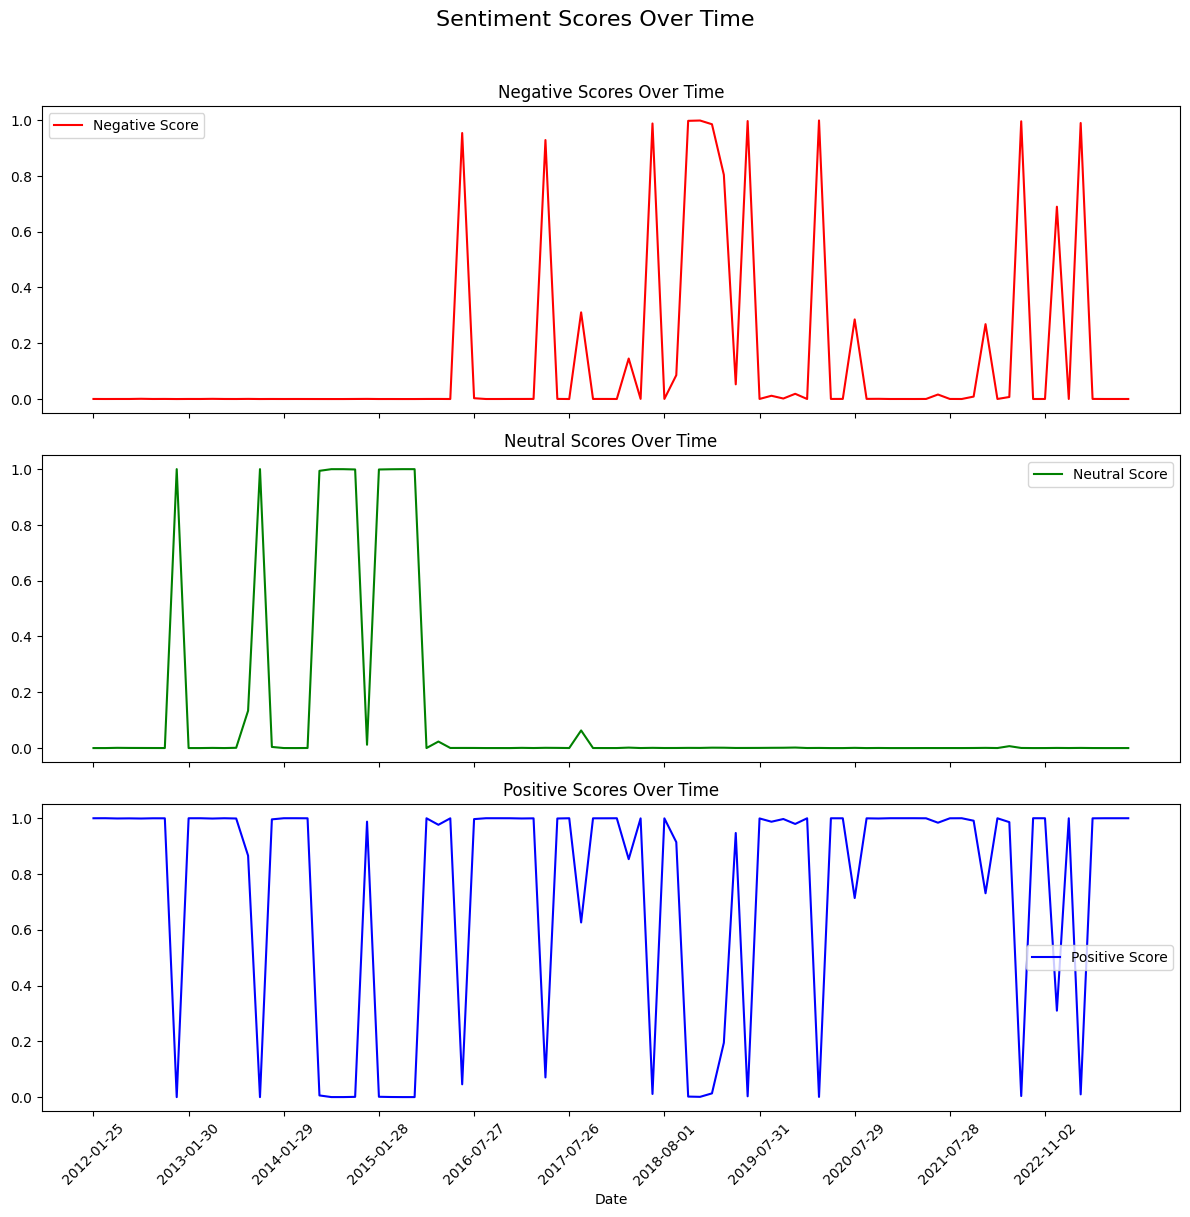

In [12]:
import matplotlib.pyplot as plt

# Convert the Timestamp objects to strings for plotting
date_str = df_fed_sentiment_score['Date'].dt.date.astype(str).tolist()

# Transform columns into lists
negative_scores = df_fed_sentiment_score['negative_score'].tolist()
neutral_scores = df_fed_sentiment_score['neutral_score'].tolist()
positive_scores = df_fed_sentiment_score['positive_score'].tolist()

# Create subplots
fig, axs = plt.subplots(3, 1, figsize=(12, 12), sharex=True, sharey=True)

# Plot negative scores
axs[0].plot(date_str, negative_scores, label='Negative Score', color='r')
axs[0].set_title('Negative Scores Over Time')
axs[0].legend()

# Plot neutral scores
axs[1].plot(date_str, neutral_scores, label='Neutral Score', color='g')
axs[1].set_title('Neutral Scores Over Time')
axs[1].legend()

# Plot positive scores
axs[2].plot(date_str, positive_scores, label='Positive Score', color='b')
axs[2].set_title('Positive Scores Over Time')
axs[2].legend()

# Set common labels
fig.suptitle('Sentiment Scores Over Time', fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.96])  # Adjust layout to accommodate suptitle

# Rotate x-axis labels by 45 degrees and display every third date
for ax in axs:
    ax.set_xticks(ax.get_xticks()[::2])  # Display every third tick
    ax.tick_params(axis='x', rotation=45)

plt.xlabel('Date')

# Display the plot
plt.show()

<ipython-input-13-6d451c9a0c54>:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  monthly_avg_scores = df_fed_sentiment_score.groupby('month_year').mean()


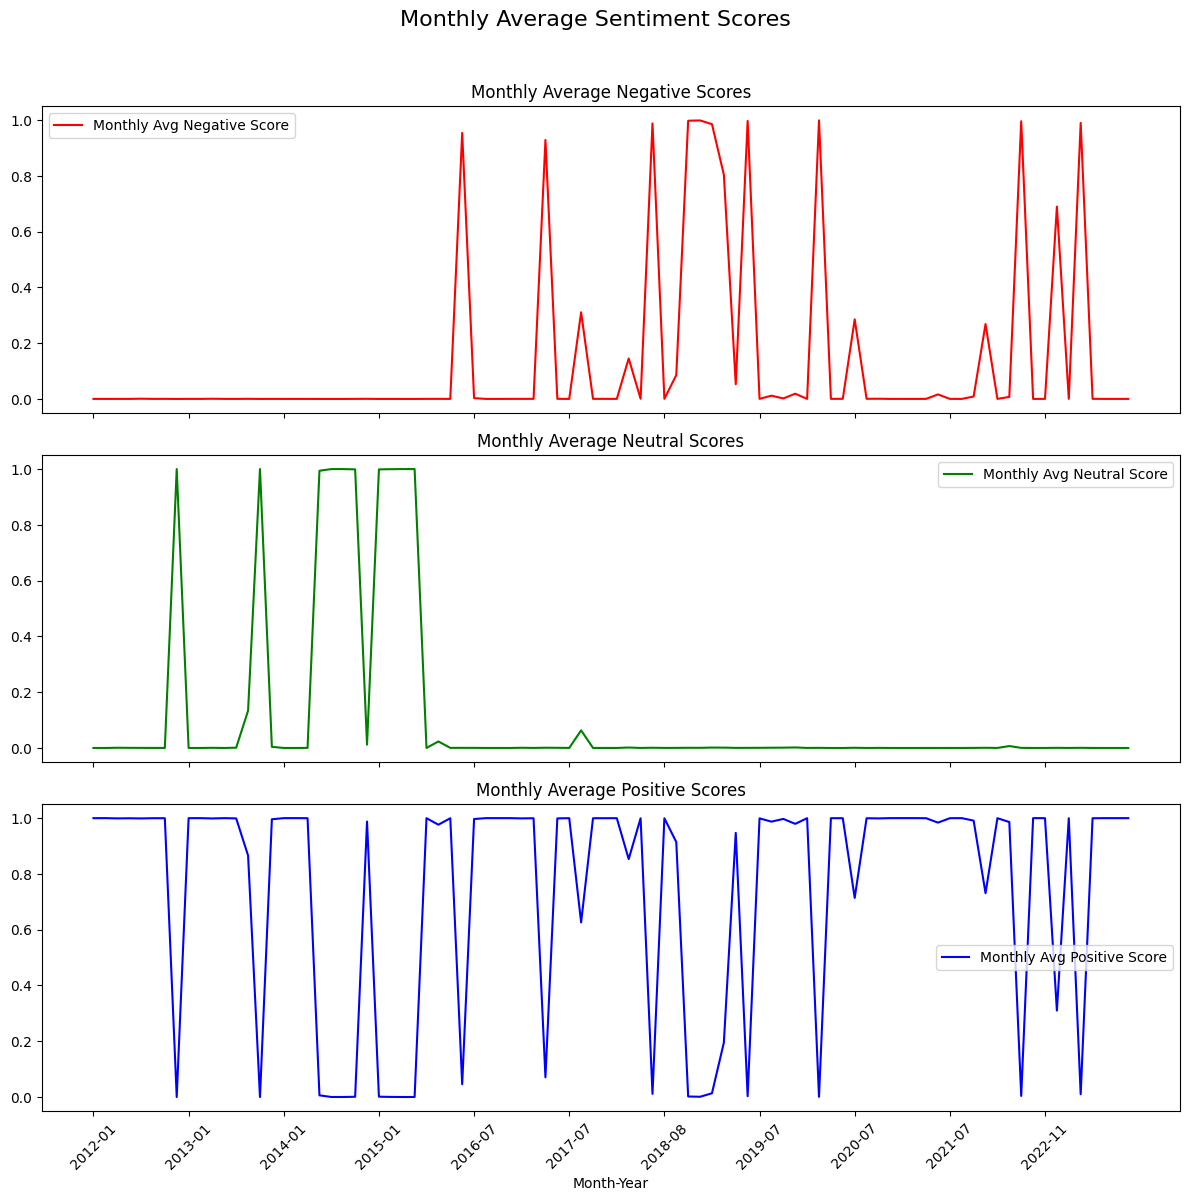

In [13]:
import matplotlib.pyplot as plt

# Convert the Timestamp objects to month-year format for grouping
df_fed_sentiment_score['month_year'] = df_fed_sentiment_score['Date'].dt.to_period('M')

# Group by month-year and compute the mean for each group
monthly_avg_scores = df_fed_sentiment_score.groupby('month_year').mean()

# Extract month-year as strings for plotting
months = monthly_avg_scores.index.astype(str).tolist()

# Extract monthly average scores
monthly_negative_scores = monthly_avg_scores['negative_score'].tolist()
monthly_neutral_scores = monthly_avg_scores['neutral_score'].tolist()
monthly_positive_scores = monthly_avg_scores['positive_score'].tolist()

# Create subplots
fig, axs = plt.subplots(3, 1, figsize=(12, 12), sharex=True, sharey=True)

# Plot monthly average negative scores
axs[0].plot(months, monthly_negative_scores, label='Monthly Avg Negative Score', color='r')
axs[0].set_title('Monthly Average Negative Scores')
axs[0].legend()

# Plot monthly average neutral scores
axs[1].plot(months, monthly_neutral_scores, label='Monthly Avg Neutral Score', color='g')
axs[1].set_title('Monthly Average Neutral Scores')
axs[1].legend()

# Plot monthly average positive scores
axs[2].plot(months, monthly_positive_scores, label='Monthly Avg Positive Score', color='b')
axs[2].set_title('Monthly Average Positive Scores')
axs[2].legend()

# Set common labels
fig.suptitle('Monthly Average Sentiment Scores', fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.96])  # Adjust layout to accommodate suptitle

# Rotate x-axis labels by 45 degrees and display every third date
for ax in axs:
    ax.set_xticks(ax.get_xticks()[::2])  # Display every third tick
    ax.tick_params(axis='x', rotation=45)

plt.xlabel('Month-Year')

# Display the plot
plt.show()
